# Loading libraries

In [1]:
import torch
from torchvision import models, transforms
import os
from torch_snippets import *
import cv2
from torchvision.ops import nms

from torch.utils.data import Dataset, DataLoader


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
base_url = "6\\bus-trucks"
image_root = os.path.join(base_url,'images','images')
df_raw = pd.read_csv(os.path.join(base_url,'df.csv'))

In [4]:
%pwd

'c:\\Users\\rachi\\Desktop\\inueuron\\FSDS\\books\\Modern-Computer-Vision-with-PyTorch'

# Faster RCNN

In [4]:
df_raw.LabelName.unique()

array(['Bus', 'Truck'], dtype=object)

In [5]:
label2target = {}
for index, label in enumerate(df_raw.LabelName.unique()):
    # print(index,label)
    label2target[label] = index+1

In [6]:
label2target

{'Bus': 1, 'Truck': 2}

In [17]:
label2target['background'] = 0

In [18]:
label2target

{'Bus': 1, 'Truck': 2, 'background': 0}

In [19]:
target2label = {t:l for l,t in label2target.items()}

In [20]:
target2label

{1: 'Bus', 2: 'Truck', 0: 'background'}

In [21]:
num_classes = len(label2target)

In [23]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [48]:
class OpenDataset(Dataset):
    w,h = 224, 224
    def __init__(self, df, image_dir = image_root):
        self.df = df
        self.image_dir = image_dir
        self.files = Glob(os.path.join(self.image_dir,"*.jpg"))
        # print(self.files)
        self.image_infos = df.ImageID.unique()
        # print(len(self.image_infos))
        
    def __getitem__(self, ix):
        
        # Load Image and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id,self.files)
        
        #img = read(img_path, 1) # different
        
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w,self.h), resample = Image.BILINEAR )) / 255.
        
        data = self.df[self.df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        
        data = data[['XMin','YMin','XMax','YMax']].values
        
        
        ## scale ground truths to 224,224
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        
        boxes = data.astype(np.uint32).tolist()
        
        
        # torch FRCNN expects ground truths as dictionary of tensors
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))
    
    
    def __len__(self):
        return len(self.image_infos)

        
        

        

In [49]:
from sklearn.model_selection import train_test_split

trn_ids, val_ids = train_test_split(df_raw.ImageID.unique(), test_size=0.1, random_state=99)

In [50]:
trn_df, val_df = df_raw[df_raw['ImageID'].isin(trn_ids)], df_raw[df_raw['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

(21598, 2464)

In [51]:
train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

In [53]:
train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

In [54]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [56]:
faster_rcnn = models.detection.fasterrcnn_resnet50_fpn(pretrained = True, progress= True)

c:\Users\rachi\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rachi\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\rachi/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [58]:
print(faster_rcnn)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
        )
      )
      (layer2): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): FrozenBatchNorm2d(512, eps=0.0)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (2): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=0.0)
          (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(512, eps=0.0)
          (relu): ReLU(inplace=True)
        )
        (3): Bottleneck(
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=0.0)
          (conv2): C

In [62]:
faster_rcnn.roi_heads.box_predictor.cls_score.in_features

1024

In [59]:
FastRCNNPredictor?

Init signature: FastRCNNPredictor(in_channels, num_classes)
Docstring:     
Standard classification + bounding box regression layers
for Fast R-CNN.

Args:
    in_channels (int): number of input channels
    num_classes (int): number of output classes (including background)
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           c:\users\rachi\anaconda3\lib\site-packages\torchvision\models\detection\faster_rcnn.py
Type:           type
Subclasses:     


In [63]:
def get_model():
    model = models.detection.faster_rcnn.fasterrcnn_resnet50_fpn(pretrained = True, progress=True)
    in_features = faster_rcnn.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor  = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [66]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [69]:

model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 1
log = Report(n_epochs)
     

In [70]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

EPOCH: 1.000  val_loss: 0.193  val_loc_loss: 0.076  val_regr_loss: 0.094  val_objectness_loss: 0.012  val_rpn_box_reg_loss: 0.011  (3243.83s - 0.00s remaining)))))))

ZeroDivisionError: integer division or modulo by zero

100%|██████████| 102/102 [00:00<00:00, 896.03it/s]


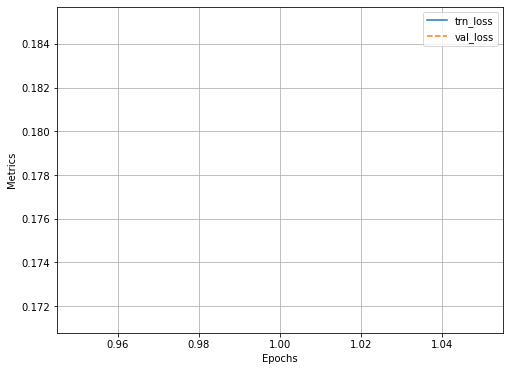

In [71]:
log.plot_epochs(['trn_loss','val_loss'])

In [75]:

from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


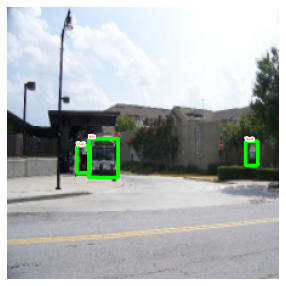

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


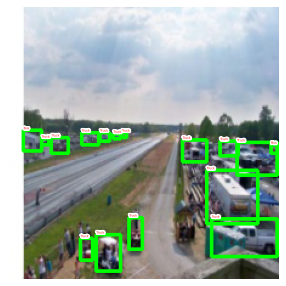

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


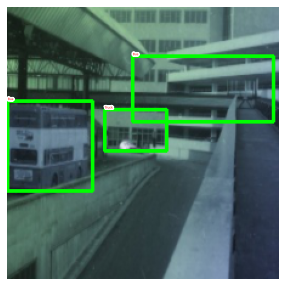

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


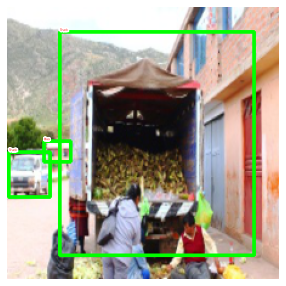

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


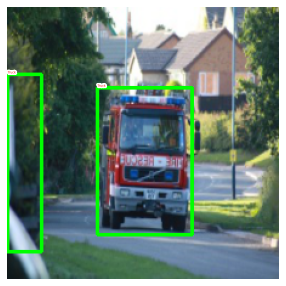

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


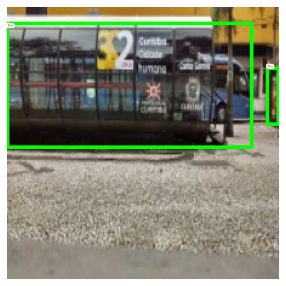

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


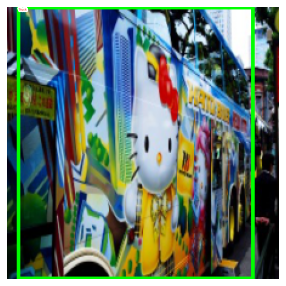

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


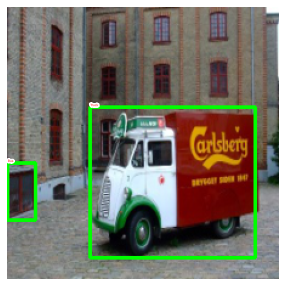

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


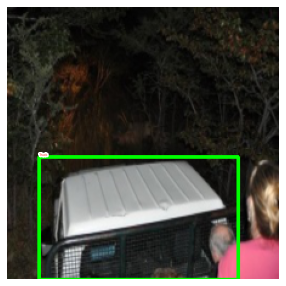

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


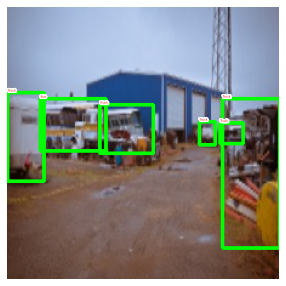

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


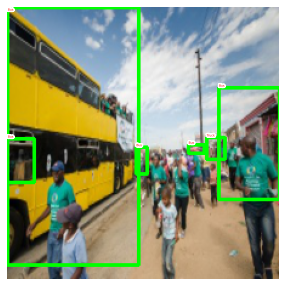

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


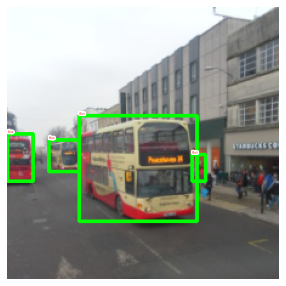

In [76]:

model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==3: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)

# YOLO

Yolo v4 in seperate file. Will do Yolo v5 here


youtube:
https://www.youtube.com/watch?v=M2iklVDKsw0&list=PLkz_y24mlSJYWpwFbU8fyaBSwihoVHiJz


github:
https://github.com/entbappy/Sign-Language-Generation-From-Video-using-YOLOV5

In [4]:
os.chdir("7")

In [5]:
if not os.path.exists("yolov5"):
    !git clone https://github.com/ultralytics/yolov5.git

In [6]:
%cd yolov5

c:\Users\rachi\Desktop\inueuron\FSDS\books\Modern-Computer-Vision-with-PyTorch\7\yolov5


In [7]:
import torch

from IPython.display import Image, clear_output 

In [8]:
%cd ..

c:\Users\rachi\Desktop\inueuron\FSDS\books\Modern-Computer-Vision-with-PyTorch\7


In [9]:
%cd data

c:\Users\rachi\Desktop\inueuron\FSDS\books\Modern-Computer-Vision-with-PyTorch\7\data


In [10]:
import yaml

In [11]:
def read_yaml(filepath):
    with open(filepath,'rb') as yaml_file:
        return yaml.safe_load(yaml_file)

In [12]:
data = read_yaml("data.yaml")

In [13]:
data

{'train': '../data/train/images',
 'val': '../data/test/images',
 'nc': 2,
 'names': ['Bus', 'Truck']}

#### Model architecture

In [14]:
os.chdir("..")

In [15]:
%pwd

'c:\\Users\\rachi\\Desktop\\inueuron\\FSDS\\books\\Modern-Computer-Vision-with-PyTorch\\7'

In [16]:
# will use the small variant of yolo v5

yolo_v5s_config = read_yaml("yolov5\\models\\yolov5s.yaml")

In [17]:
print(yolo_v5s_config)

{
    'nc': 2,
    'depth_multiple': 0.33,
    'width_multiple': 0.5,
    'anchors': [[10, 13, 16, 30, 33, 23], [30, 61, 62, 45, 59, 119], [116, 90, 156, 198, 373, 326]],
    'backbone': [
        [-1, 1, 'Conv', [64, 6, 2, 2]],
        [-1, 1, 'Conv', [128, 3, 2]],
        [-1, 3, 'C3', [128]],
        [-1, 1, 'Conv', [256, 3, 2]],
        [-1, 6, 'C3', [256]],
        [-1, 1, 'Conv', [512, 3, 2]],
        [-1, 9, 'C3', [512]],
        [-1, 1, 'Conv', [1024, 3, 2]],
        [-1, 3, 'C3', [1024]],
        [-1, 1, 'SPPF', [1024, 5]]
    ],
    'head': [
        [-1, 1, 'Conv', [512, 1, 1]],
        [-1, 1, 'nn.Upsample', ['None', 2, 'nearest']],
        [[-1, 6], 1, 'Concat', [1]],
        [-1, 3, 'C3', [512, False]],
        [-1, 1, 'Conv', [256, 1, 1]],
        [-1, 1, 'nn.Upsample', ['None', 2, 'nearest']],
        [[-1, 4], 1, 'Concat', [1]],
        [-1, 3, 'C3', [256, False]],
        [-1, 1, 'Conv', [256, 3, 2]],
        [[-1, 14], 1, 'Concat', [1]],
        [-1, 3, 'C3', [512, False]],
        [-1, 1, 'Conv', [512, 3, 2]],
        [[-1, 10], 1, 'Concat', [1]],
        [-1, 3, 'C3', [1024, False]],
        [[17, 20, 23], 1, 'Detect', ['nc', 'anchors']]
    ]
}

In [18]:
## will need to update this

In [19]:
import re, shutil, tempfile

def sed_inplace(filename, pattern, repl):
    '''
    Perform the pure-Python equivalent of in-place `sed` substitution: e.g.,
    `sed -i -e 's/'${pattern}'/'${repl}' "${filename}"`.
    '''
    # For efficiency, precompile the passed regular expression.
    pattern_compiled = re.compile(pattern)

    # For portability, NamedTemporaryFile() defaults to mode "w+b" (i.e., binary
    # writing with updating). This is usually a good thing. In this case,
    # however, binary writing imposes non-trivial encoding constraints trivially
    # resolved by switching to text writing. Let's do that.
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as tmp_file:
        with open(filename) as src_file:
            for line in src_file:
                tmp_file.write(pattern_compiled.sub(repl, line))

    # Overwrite the original file with the munged temporary file in a
    # manner preserving file attributes (e.g., permissions).
    shutil.copystat(filename, tmp_file.name)
    shutil.move(tmp_file.name, filename)


In [20]:
## we have 2 classes


In [21]:
num_classes = data['nc']

In [22]:
%pwd

'c:\\Users\\rachi\\Desktop\\inueuron\\FSDS\\books\\Modern-Computer-Vision-with-PyTorch\\7'

In [23]:
yolo_v5s_config_file_path = "yolov5\\models\\yolov5s.yaml"

In [24]:
sed_inplace(yolo_v5s_config_file_path, "nc: 80", f"nc: {num_classes}")

### Model Training

In [25]:
%pwd

'c:\\Users\\rachi\\Desktop\\inueuron\\FSDS\\books\\Modern-Computer-Vision-with-PyTorch\\7'

#### dont add single quotes for arguements, add double quotes

In [33]:
!python yolov5/train.py --img 415 --batch 16 --epochs 5 --data "data/data.yaml" --cfg "yolov5/models/yolov5s.yaml" --weights yolov5s.pt --name yolov5s_results --cache

Traceback (most recent call last):
  File "yolov5/train.py", line 30, in <module>
    import torch
  File "c:\Users\rachi\anaconda3\lib\site-packages\torch\__init__.py", line 128, in <module>
    raise err
OSError: [WinError 1455] The paging file is too small for this operation to complete. Error loading "c:\Users\rachi\anaconda3\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.


In [31]:
%pwd

'c:\\Users\\rachi\\Desktop\\inueuron\\FSDS\\books\\Modern-Computer-Vision-with-PyTorch\\7'

In [28]:

#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Yolo v5 try 2

# Using the model generated from yolo_v5.ipynb

In [4]:
os.chdir("7")

In [5]:
os.chdir("yolov5")

In [6]:
7\bus-truck-images\00a4decd12ae97b9.jpg

SyntaxError: unexpected character after line continuation character (<ipython-input-6-043f4d102ba6>, line 1)

In [16]:
!python detect.py --weights ../best.pt --img 415 --conf 0.05 --source ../bus-truck-images/00a4decd12ae97b9.jpg --view-img 

detect: weights=['../best.pt'], source=../bus-truck-images/00a4decd12ae97b9.jpg, data=data\coco128.yaml, imgsz=[415, 415], conf_thres=0.05, iou_thres=0.45, max_det=1000, device=, view_img=True, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-100-g4d28fec Python-3.8.8 torch-1.13.1+cu116 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
WARNING  --img-size [415, 415] must be multiple of max stride 32, updating to [416, 416]
image 1/1 C:\Users\rachi\Desktop\inueuron\FSDS\books\Modern-Computer-Vision-with-PyTorch\7\bus-truck-images\00a4decd12ae97b9.jpg: 320x416 (no detections), 13.4ms
Speed: 0.0ms pre-process, 13.4ms inference, 1.0ms NMS per image at shape (1, 3

In [14]:
%pwd

'c:\\Users\\rachi\\Desktop\\inueuron\\FSDS\\books\\Modern-Computer-Vision-with-PyTorch\\7\\data'